In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.cm import tab10, tab20c,tab20b
from covid_model.analysis.charts import plot_immunity_props,plot_seir_comparments,plot_vacc_status_props,plot_variant_props
from os.path import split,join
import pickle
import itertools
import datetime

In [2]:
reg_to_name = {"coe":"Colorado East Region",
               "cow":"Colorado West Region",
               "con":"Colorado North Region"}

In [ ]:
for region in ["con","cow","coe"]:
    region_name = reg_to_name[region]
    with open(f"solution_df_{region}_mobility_seed.pkl","rb") as f:
        solution_df = pickle.load(f)
    solution_df.set_index(pd.date_range("2020-01-24",periods=len(solution_df)),inplace=True)
    solution_df = solution_df.iloc[:767]
    
    output_dir = "11_22_charts"
    
    plot_seir_comparments(df=solution_df,
                          fig_title="SEIR Compartments",
                          fig_filename=join(output_dir,f"seir_status_{region}.png"))
    
    plot_immunity_props(df=solution_df,
                        fig_title="Immunity Proportions",
                        fig_filename=join(output_dir,f"immun_status_{region}.png"))
    
    plot_vacc_status_props(df=solution_df,
                           fig_title="Vaccination Status",
                           fig_filename=join(output_dir,f"vacc_status_{region}.png"))
    
    plot_variant_props(df=solution_df,
                       fig_title="Variant Distribution",
                       fig_filename=join(output_dir,f"variant_props_{region}.png"))
    
    

In [3]:
def draw_stackplot(ax,df,f_title,l_title,ylabel,xlabel,colors,figsize=(14,9)):
    ax.stackplot(df.columns,df.values,labels=df.index,colors=colors)
    ax.legend(title=l_title,fancybox=False,edgecolor="black",bbox_to_anchor=(1.0,1.01),loc="upper left",fontsize=14,title_fontsize=14)
    ax.set_xlim(df.columns.min(),df.columns.max())
    #ax.set_ylim(
    ax.set_ylabel(ylabel,fontsize=14)
    ax.set_xlabel(xlabel,fontsize=14)
    ax.set_title(f_title,fontsize=16)
    plt.tight_layout()

In [3]:
vacc_regional.index.get_level_values("vacc").unique()

NameError: name 'vacc_regional' is not defined

In [4]:
import seaborn as sns

In [33]:
all_variant = []
for tc in ["0.7955","0.7972","0.8424"]:
    today = datetime.date.today()
    with open(f"fit_batch_34_run_type_fit_tc_{tc}_model_solution_ydf.pkl","rb") as f:
        solution_df = pickle.load(f)
    solution_df.set_index(pd.date_range("2020-01-24",periods=len(solution_df)),inplace=True)
    variant_regional = solution_df.drop(axis=1,level="seir",labels=["S","E","D"]).groupby(level=["variant"],axis=1).sum().T
    variant_regional = variant_regional.divide(variant_regional.sum(axis=0))
    variant_regional.loc["none",variant_regional.loc["none",:].isna()] = 1.0
    variant_regional.fillna(0.0,inplace=True)
    variant_regional = variant_regional.T
    variant_regional["TC"] = tc
    variant_regional.drop(columns=["alpha","delta","none","omicron","wildtype"],inplace=True)
    variant_regional = variant_regional.loc["2022-11-01":"2023-01-01"]
    all_variant.append(variant_regional)
all_variant = pd.concat(all_variant)

<AxesSubplot:xlabel='index', ylabel='value'>

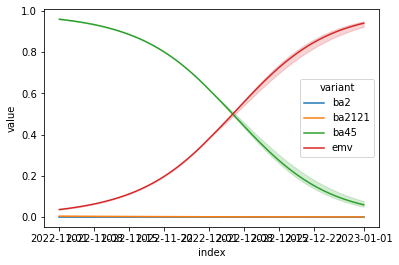

In [34]:
plot_df = all_variant.set_index("TC",append=True).melt(ignore_index=False).reset_index(level="TC",drop=True).reset_index()
sns.lineplot(data=plot_df,x="index",y="value",hue="variant",errorbar=lambda v: (v.min(),v.max()))

In [ ]:
fig,ax = plt.subplots(figsize=(14,9))
plot_variant = variant_regional.drop(index=["alpha","delta","none","omicron","wildtype"]).T.loc["2022-09-01":"2023-01-01"]
for col in plot_variant.columns:
    ax.plot(plot_variant[col],label=col)
ax.legend()

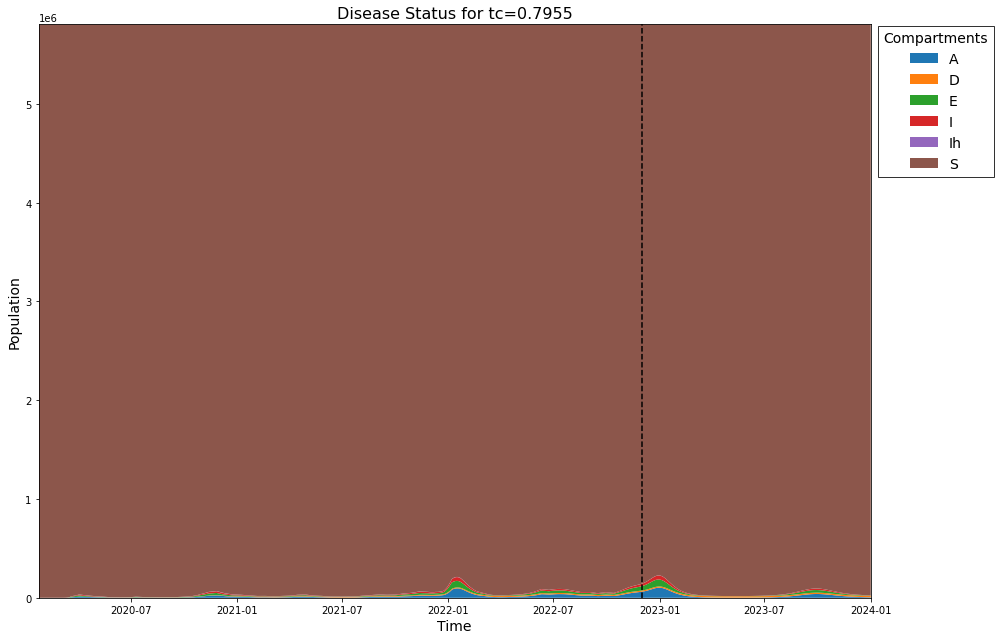

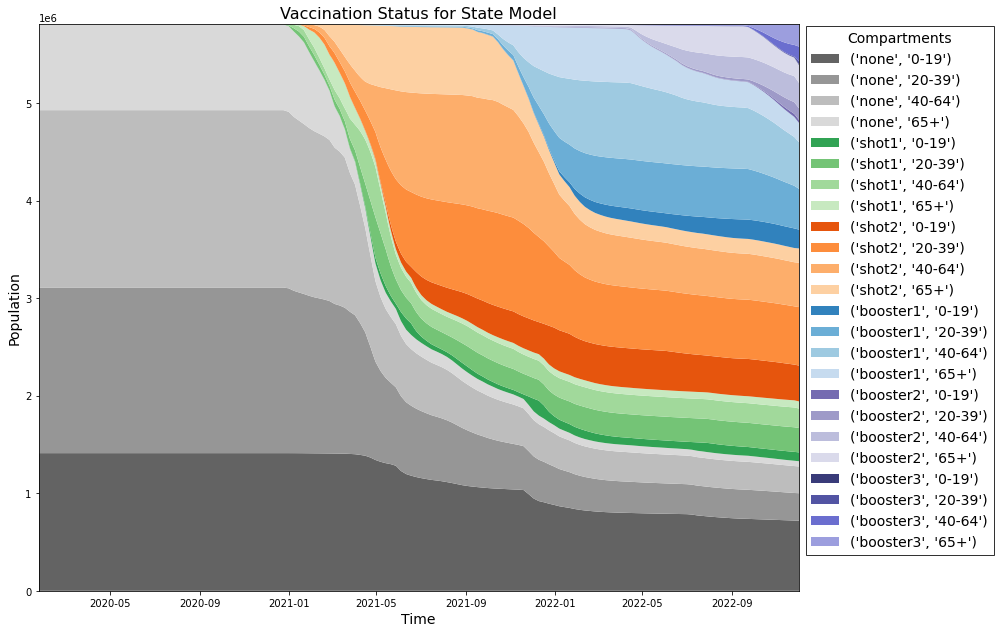

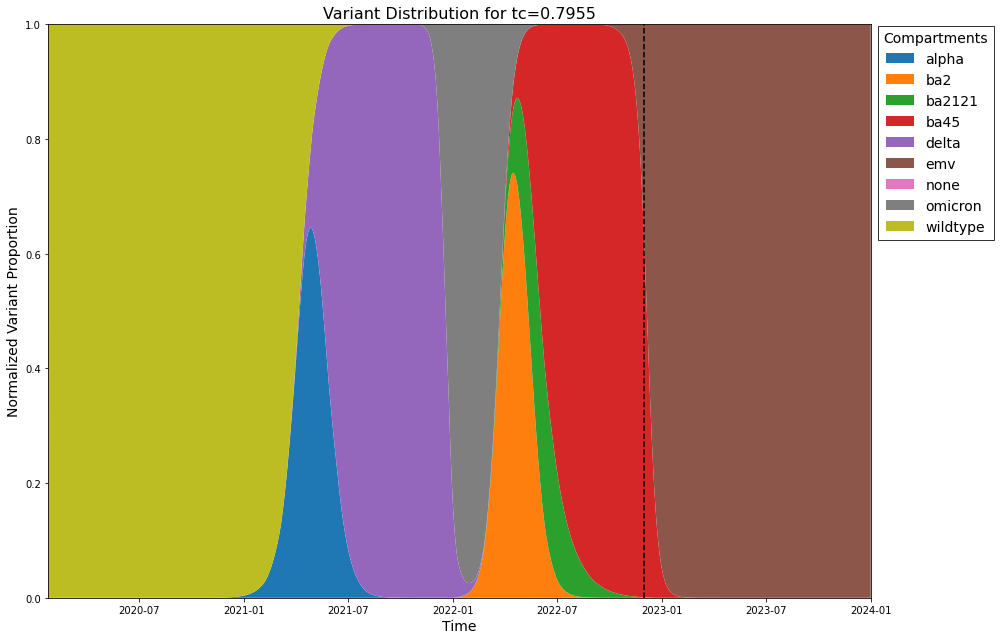

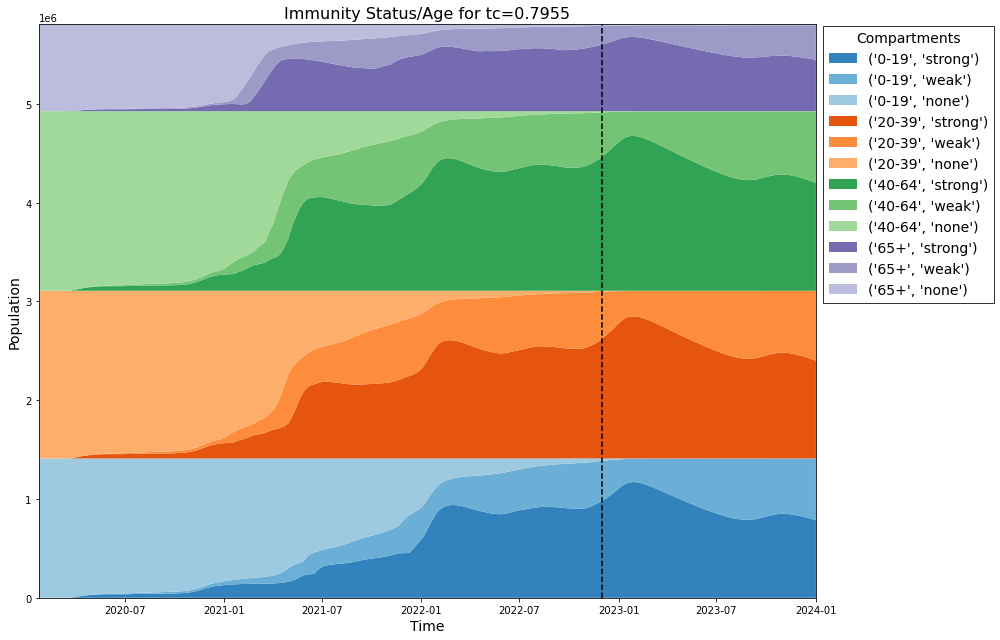

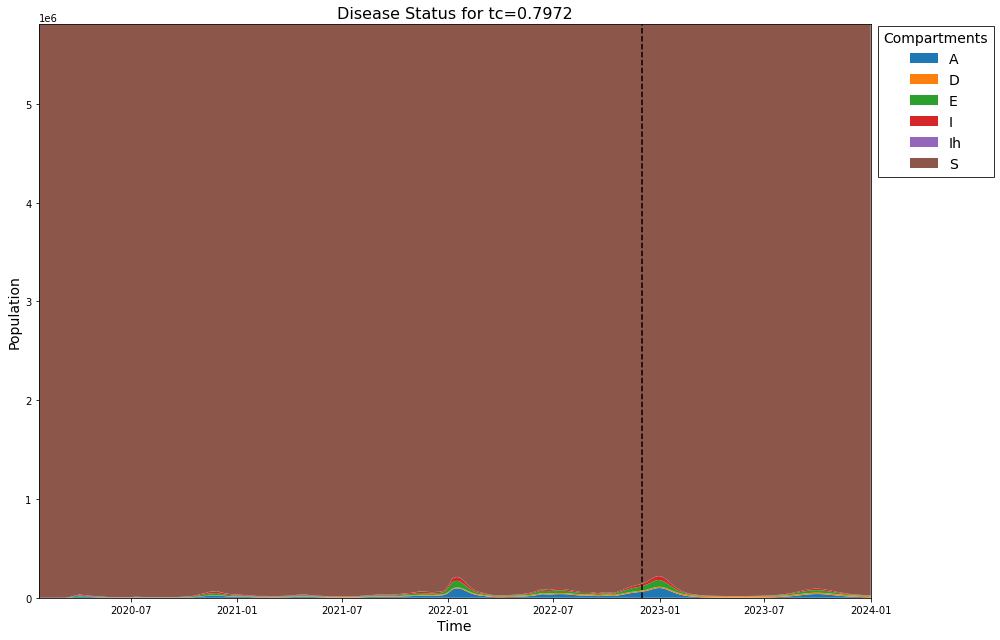

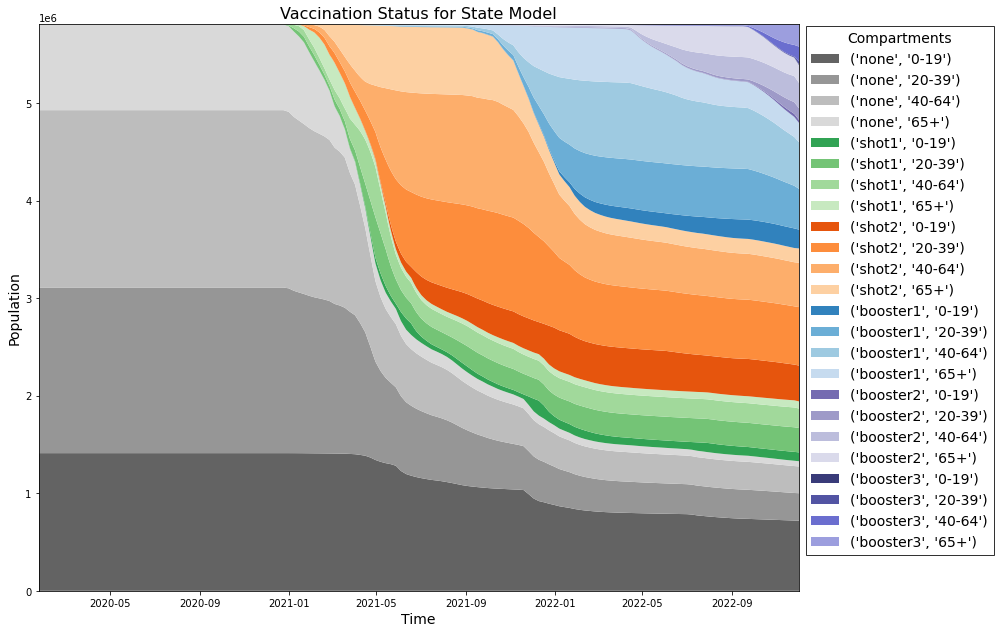

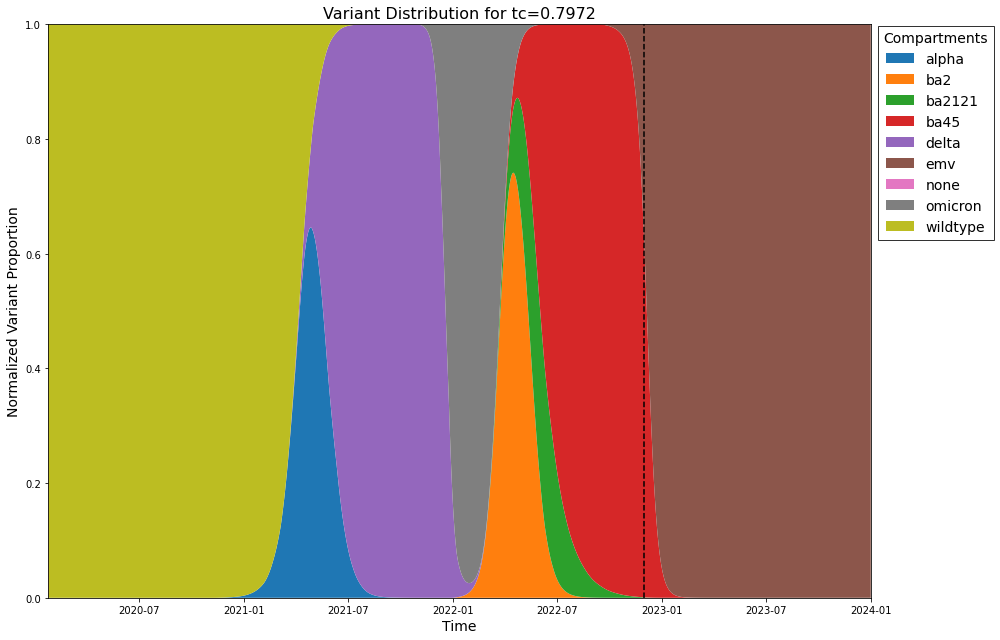

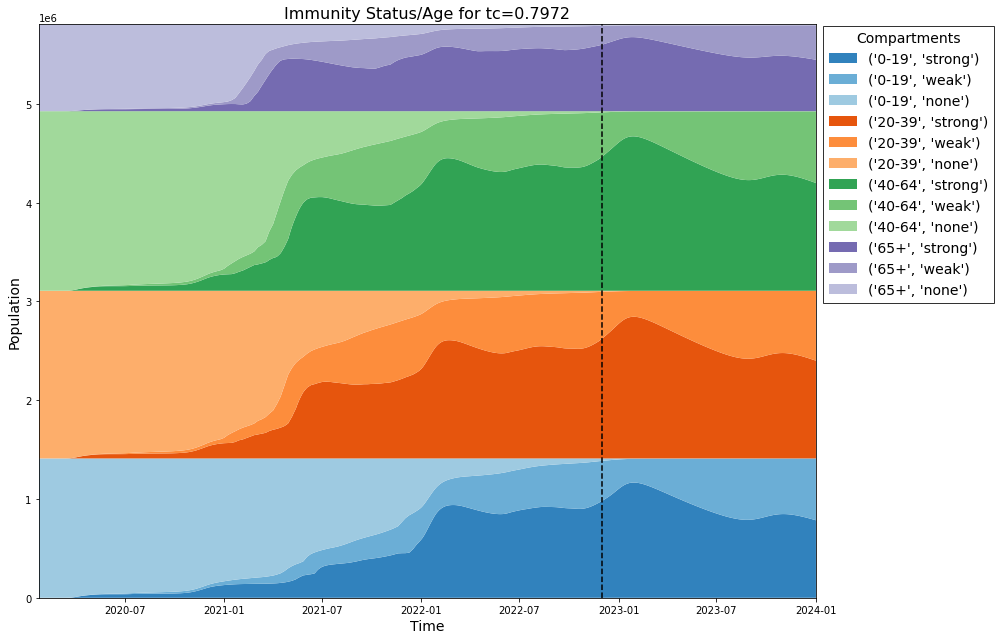

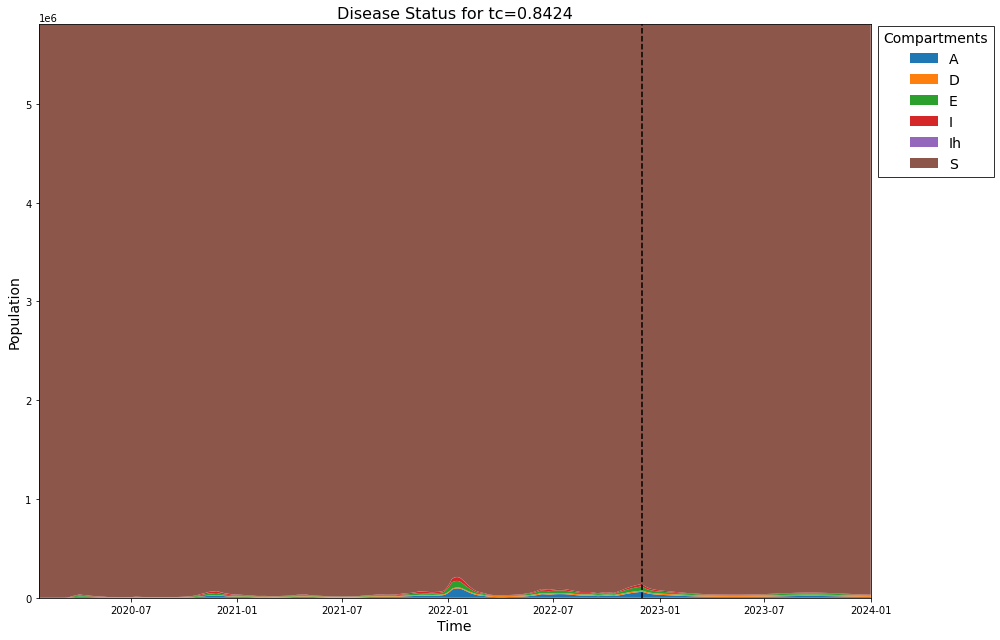

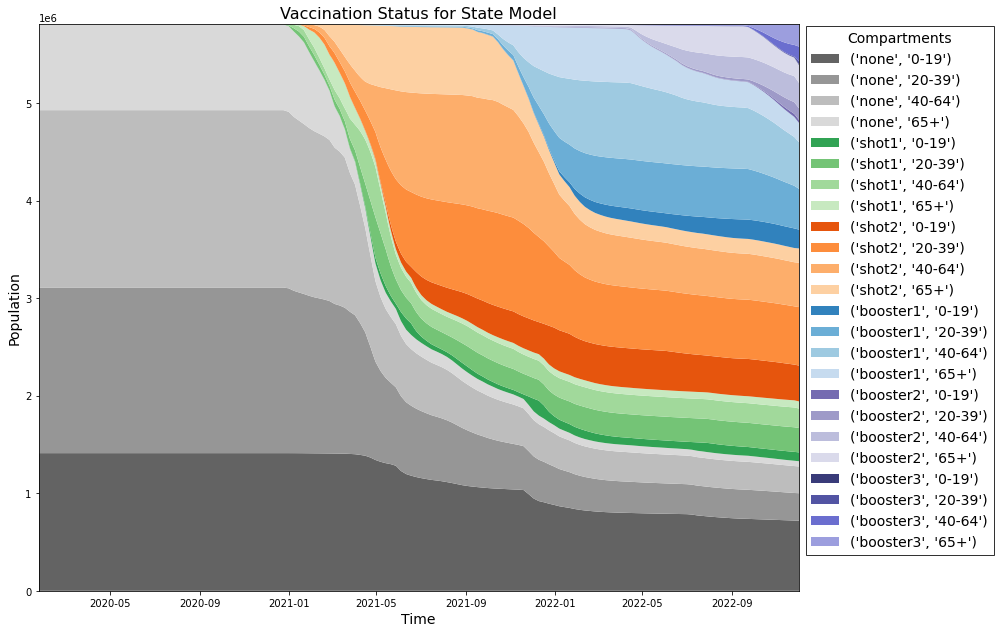

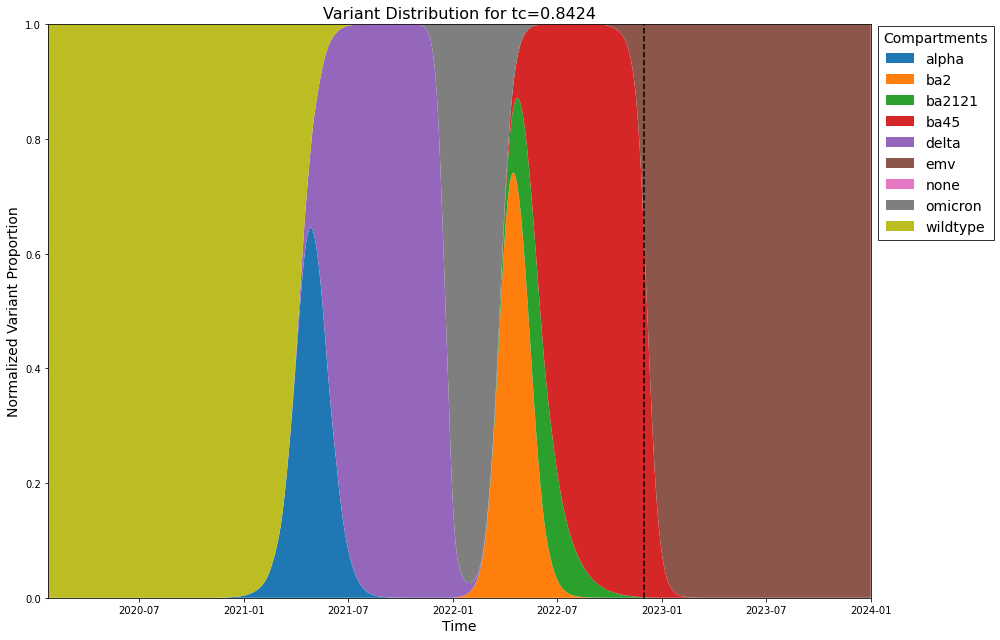

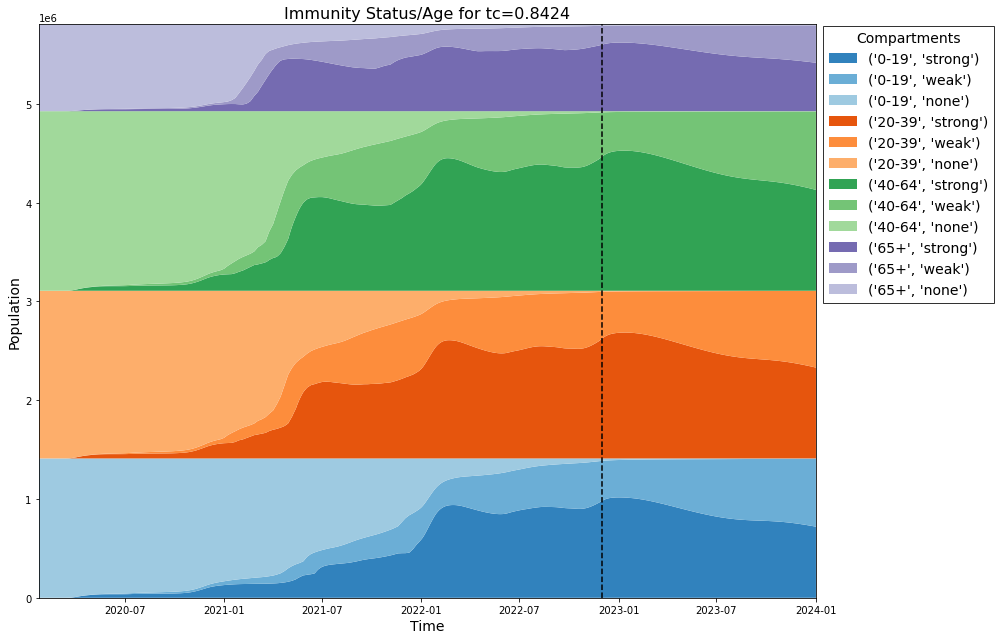

In [15]:
files = ["fit_batch_34_run_type_fit_tc_0.7955_model_solution_ydf.pkl",
         "fit_batch_34_run_type_fit_tc_0.7972_model_solution_ydf.pkl",
         "fit_batch_34_run_type_fit_tc_0.8424_model_solution_ydf.pkl"]

for tc in ["0.7955","0.7972","0.8424"]:
    today = datetime.date.today()
    with open(f"fit_batch_34_run_type_fit_tc_{tc}_model_solution_ydf.pkl","rb") as f:
        solution_df = pickle.load(f)
    solution_df.set_index(pd.date_range("2020-01-24",periods=len(solution_df)),inplace=True)
    solution_df = solution_df
    #solution_df = solution_df.iloc[:767]
    
    # SEIR Status
    seir_regional = solution_df.groupby(level="seir",axis=1).sum().T
    fig,ax = plt.subplots(figsize=(14,9))
    draw_stackplot(ax=ax,
                   df=seir_regional,
                   f_title=f"Disease Status for tc={tc}",
                   l_title="Compartments",
                   xlabel="Time",
                   ylabel="Population",
                   colors=[tab10(i) for i in range(seir_regional.index.nunique())])
    ax.axvline(today,0,1,color="black",linestyle="--")
    ax.set_ylim(0,seir_regional.sum().max())
    plt.savefig(f"seir_status_{tc}.png")
    
    # Vaccination Status
    vacc_regional = solution_df.groupby(level=["vacc","age"],axis=1).sum().T
    #vacc_regional = vacc_regional.reindex(["booster3","booster2","booster1","shot2","shot1","none"],level=0)
    vacc_regional = vacc_regional.reindex(["none","shot1","shot2","booster1","booster2","booster3"],level=0)
    # We use gray for the none vaccination status, and colors otherwise
    colors = []
    #color_groups = np.array([5,3,0,1,2,4])
    color_groups = np.array([4,2,1,0,3,5])
    for vacc,cgrp in zip(vacc_regional.index.get_level_values("vacc").unique(),color_groups):
        for j,age in enumerate(vacc_regional.index.get_level_values("age").unique()):
            if cgrp >= 5:
                colors.append(tab20b((cgrp*(cgrp-5))+j))
            else:
                colors.append(tab20c((cgrp*4)+j))
    fig,ax = plt.subplots(figsize=(14,9))
    draw_stackplot(ax=ax,
                   df=vacc_regional,
                   f_title=f"Vaccination Status for State Model",
                   l_title="Compartments",
                   xlabel="Time",
                   ylabel="Population",
                   colors=colors)
    #ax.axvline(datetime.date.today(),0,1,color="black",linestyle="--")
    ax.set_ylim(0,vacc_regional.sum().max())
    ax.set_xlim(right=today)
    plt.savefig(f"vacc_status_state.png")
    
    # Variant Proportion
    variant_regional = solution_df.drop(axis=1,level="seir",labels=["S","E","D"]).groupby(level=["variant"],axis=1).sum().T
    variant_regional = variant_regional.divide(variant_regional.sum(axis=0))
    variant_regional.loc["none",variant_regional.loc["none",:].isna()] = 1.0
    variant_regional.fillna(0.0,inplace=True)
    fig,ax = plt.subplots(figsize=(14,9))
    draw_stackplot(ax=ax,
                   df=variant_regional,
                   f_title=f"Variant Distribution for tc={tc}",
                   l_title="Compartments",
                   ylabel="Normalized Variant Proportion",
                   xlabel="Time",
                   colors=[tab10(i) for i in range(variant_regional.index.nunique())])
    ax.axvline(datetime.date.today(),0,1,color="black",linestyle="--")
    ax.set_ylim(0,1)
    plt.savefig(f"variant_proportion_{tc}.png")
    
    # Immunity Proportion
    immun_regional = solution_df.groupby(level=["age","immun"],axis=1).sum().T
    # reorder so that the colors make more intuitive sense.
    immun_regional = immun_regional.reindex(index=["strong","weak","none"],level=1)
    colors = []
    for i,age in enumerate(immun_regional.index.get_level_values("age").unique()):
        for j,immun in enumerate(immun_regional.index.get_level_values("immun").unique()):
            colors.append(tab20c((4*i)+j))
    fig,ax = plt.subplots(figsize=(14,9))
    draw_stackplot(ax=ax,
                   df=immun_regional,
                   f_title=f"Immunity Status/Age for tc={tc}",
                   l_title="Compartments",
                   xlabel="Time",
                   ylabel="Population",
                   colors=colors)
    ax.axvline(datetime.date.today(),0,1,color="black",linestyle="--")
    ax.set_ylim(0,immun_regional.sum().max())
    plt.savefig(f"immunity_status_{tc}.png")

# State Projections

In [ ]:
import glob
import pickle
import seaborn as sns
from os.path import split
split(glob.glob("11_18_briefing/*.pkl")[0])

In [ ]:
ax.get_legend_handles_labels()

In [ ]:
for file in glob.glob("11_18_briefing/*.pkl"):
    
    with open(file,"rb") as f:
        solution_df = pickle.load(f)
    solution_df.set_index(pd.date_range("2020-01-24",periods=len(solution_df)),inplace=True)
    solution_df = solution_df.loc["2022-07-01":"2023-01-01"]
    out_filename = file.replace("_solution_ydf.pkl","variant_proportion.png")
    print(out_filename)
    # Variant Proportion
    variant_regional = solution_df.drop(axis=1,level="seir",labels=["S","E","D"]).groupby(level=["variant"],axis=1).sum().T
    variant_regional = variant_regional.divide(variant_regional.sum(axis=0))
    variant_regional.loc["none",variant_regional.loc["none",:].isna()] = 1.0
    variant_regional.fillna(0.0,inplace=True)
    fig,ax = plt.subplots(figsize=(14,9))
    colors = [c for i,c in enumerate(tab10.colors) if i != 7]
    draw_stackplot(ax=ax,
                   df=variant_regional,
                   f_title=f"Variant Distribution for State Model",
                   l_title="Compartments",
                   ylabel="Normalized Variant Proportion",
                   xlabel="Time",
                   colors=colors)
    ax.set_ylim(0,1)
    plt.savefig(out_filename)

In [ ]:
tmp_vacc = pd.read_csv("bquxjob_75490d1b_1847c407c77.csv",index_col=["measure_date","age"])
tmp_vacc = tmp_vacc.loc[tmp_vacc.index.get_level_values("age") == "65+"]
tmp_vacc.reset_index("age",drop=True,inplace=True)
tmp_vacc["shot1"].plot()

In [ ]:
tmp_vacc

# SEIR Compartments

In [ ]:
seir_regional = solution_df.groupby(level="seir",axis=1).sum().T
seir_state = solution_df_state.groupby(level="seir",axis=1).sum().T

In [ ]:
fig,ax = plt.subplots(figsize=(14,9))
draw_stackplot(ax=ax,
               df=seir_regional,
               f_title="Disease Status for Colorado North Region",
               l_title="Compartments",
               xlabel="Time",
               ylabel="Population",
               colors=[tab10(i) for i in range(seir_regional.index.nunique())])
ax.set_ylim(0,seir_regional.sum().max())
plt.savefig("disease_status_regional.png")

In [ ]:
fig,ax = plt.subplots(figsize=(14,9))
draw_stackplot(ax=ax,
               df=seir_state,
               f_title="Disease Status for Colorado State Model",
               l_title="Compartments",
               xlabel="Time",
               ylabel="Population",
               colors=[tab10(i) for i in range(seir_regional.index.nunique())])
ax.set_ylim(0,seir_state.sum().max())
plt.savefig("disease_status_state.png")

# Vaccination Status

In [ ]:
vacc_regional = solution_df.groupby(level=["vacc","age"],axis=1).sum().T
vacc_state = solution_df_state.groupby(level=["vacc","age"],axis=1).sum().T

In [ ]:
# We use gray for the none vaccination status, and colors otherwise
colors = []
color_groups = np.array([0,1,4,2,3])
for vacc,cgrp in zip(vacc_regional.index.get_level_values("vacc").unique(),color_groups):
    for j,age in enumerate(vacc_regional.index.get_level_values("age").unique()):
        colors.append(tab20c((cgrp*4)+j))

In [ ]:
fig,ax = plt.subplots(figsize=(14,9))
draw_stackplot(ax=ax,
               df=vacc_regional,
               f_title="Vaccination Status for Colorado North Region",
               l_title="Compartments",
               xlabel="Time",
               ylabel="Population",
               colors=colors)
ax.set_ylim(0,vacc_regional.sum().max())
plt.savefig("vacc_status_regional.png")

In [ ]:
fig,ax = plt.subplots(figsize=(14,9))
draw_stackplot(ax=ax,
               df=vacc_state,
               f_title="Vaccination Status for Colorado State Model",
               l_title="Compartments",
               xlabel="Time",
               ylabel="Population",
               colors=colors)
ax.set_ylim(0,vacc_state.sum().max())
plt.savefig("vacc_status_state.png")

# Variant Distribution

In [ ]:
plot_v = solution_df.drop(axis=1,level="seir",labels=["S","E"]).groupby(level=["variant"],axis=1).sum().T
plot_v = plot_v.divide(plot_v.sum(axis=0))
plot_v.loc["none",plot_v.loc["none",:].isna()] = 1.0
plot_v.fillna(0.0,inplace=True)

In [ ]:
# Plot immunity
fig,ax = plt.subplots(figsize=(14,9))
draw_stackplot(ax=ax,
               df=plot_v,
               f_title="Variant Distribution for Colorado North Region",
               l_title="Compartments",
               ylabel="Variant Proportion",
               xlabel="Time",
               colors=[tab10(i) for i in range(plot_v.index.nunique())])
ax.set_ylim(0,1)
plt.savefig("variant_proportion_con.png")
# ax.stackplot(plot_v.columns,plot_v.values,labels=plot_v.index,colors=colors)
# ax.legend(title="Compartments",fancybox=False,edgecolor="black",bbox_to_anchor=(1.0,1.01),loc="upper left",fontsize=14,title_fontsize=14)
# ax.set_xlim(plot_v.columns.min(),plot_v.columns.max())
# #ax[1].set_ylim(0,1)
# ax.set_ylabel("Population",fontsize=14)
# ax.set_title("Variant Distribution for Colorado North Region",fontsize=16)
# ax.set_xlabel("Time",fontsize=14)
# plt.tight_layout()
#plt.savefig("immunity_comparison.png")

In [ ]:
plot_v_state = solution_df_state.drop(axis=1,level="seir",labels=["S","E"]).groupby(level=["variant"],axis=1).sum().T
plot_v_state = plot_v_state.divide(plot_v_state.sum(axis=0))
plot_v_state.loc["none",plot_v_state.loc["none",:].isna()] = 1.0
plot_v_state.fillna(0.0,inplace=True)

In [ ]:
plot_v_state

In [ ]:
fig,ax = plt.subplots(figsize=(14,9))
draw_stackplot(ax=ax,
               df=plot_v_state,
               f_title="Variant Distribution for Colorado State Model",
               l_title="Compartments",
               ylabel="Variant Proportion",
               xlabel="Time",
               colors=[tab10(i) for i in range(plot_v.index.nunique())])
ax.set_ylim(0,1)
plt.savefig("variant_proportion_state.png")

In [ ]:
# Plot immunity
plot_v = solution_df.groupby(axis=1,level=["immun","age"]).sum().T
fig,ax = plt.subplots(figsize=(29,9),ncols=2,sharex=True,sharey=True)
ax[0].stackplot(plot_v.columns,plot_v.values,labels=plot_v.index,colors=[tab20c(i) for i in np.arange(12)])
ax[0].legend(title="Compartments",fancybox=False,edgecolor="black",bbox_to_anchor=(1.0,1.01),loc="upper left",fontsize=14,title_fontsize=14)
ax[0].set_xlim(plot_v.columns.min(),plot_v.columns.max())
#ax[0].set_ylim(0,1)
ax[0].set_ylabel("Population",fontsize=14)
ax[0].set_title("Immunity/Age for Colorado North Region",fontsize=16)
ax[0].set_xlabel("Time",fontsize=14)
plot_v_seed = solution_df_seed_mod.groupby(axis=1,level=["immun","age"]).sum().T
ax[1].stackplot(plot_v_seed.columns,plot_v_seed.values,labels=plot_v_seed.index,colors=[tab20c(i) for i in np.arange(12)])
ax[1].legend(title="Compartments",fancybox=False,edgecolor="black",bbox_to_anchor=(1.0,1.01),loc="upper left",fontsize=14,title_fontsize=14)
ax[1].set_xlim(plot_v_seed.columns.min(),plot_v_seed.columns.max())
#ax[1].set_ylim(0,1)
ax[1].set_ylabel("Population",fontsize=14)
ax[1].set_title("Immunity/Age for Colorado North Region (modified seeding)",fontsize=16)
ax[1].set_xlabel("Time",fontsize=14)
plt.tight_layout()
plt.savefig("immunity_comparison.png")

In [ ]:
tmp_1 = solution_df_norm.groupby(axis=1,level=["age","immun"]).sum().cumsum()
plot_v = tmp_1.divide(tmp_1.sum(axis=1),axis=0).T
colors = []
for i,age in enumerate(plot_v.index.get_level_values("age").unique()):
    for j,immun in enumerate(plot_v.index.get_level_values("immun").unique()):
        colors.append(tab20c((4*i)+j))
fig,ax = plt.subplots(figsize=(14,9))
ax.stackplot(plot_v.columns,plot_v.values,labels=plot_v.index,colors=colors)
ax.legend(title="Compartments",fancybox=False,edgecolor="black",bbox_to_anchor=(1.0,1.01),loc="upper left",fontsize=14,title_fontsize=14)
ax.set_xlim(plot_v.columns.min(),plot_v.columns.max())
#ax.set_ylim(0,int(solution_df.sum(axis=1).max()))
ax.set_ylim(0,1)
ax.set_ylabel("Population",fontsize=14)
ax.set_title("Immunity/Age for Colorado State Model",fontsize=16)
ax.set_xlabel("Time",fontsize=14)
plt.tight_layout()
plt.savefig("state_model/immunity_time_2_cumulative.png")

In [ ]:
for elem in ["seir","age","vacc","variant","immun"]:
    if elem == "variant":
        plot_v = solution_df_norm.drop(level="seir",labels=["S","E"],axis=1).groupby(axis=1,level=elem).sum().T
        plot_v = plot_v.cumsum(axis=1)
        
    else:
        plot_v = solution_df_norm.groupby(axis=1,level=elem).sum().T
    plot_stack(plot_v,elem,title="state_model/"+elem+"_con",lg_title="Compartment")

In [ ]:
solution_df_norm.groupby(axis=1,level=["seir","immun"]).sum().T.iloc[:,::-1]